<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)" data-toc-modified-id="Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using percent served to convert from sentences to lengths of stay (LOS)</a></span></li></ul></li><li><span><a href="#Cleaning-validation" data-toc-modified-id="Cleaning-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cleaning validation</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

# Data cleaning
Tip: you'll probably want to save the preprocessed file to a csv the first time you run this for a new policy and then import that csv from then on out to save time. To do so, uncomment the `df.to_csv()` line at the bottom of
this section, then after you run it move that file to `recidiviz-staging>recidiviz>calculator>modeling>population_projection>state>VA>VA_data`. From then on, you can skip everything in the data cleaning section and just run the file import commented out at the end of the section.

In [92]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../sdc/webscraping/letter_data_test_{i}.csv',
        index_col=0
    ) for i in range(14)
])

print('number of null disposition dates: ', sdc_data['Disposition Date'].isnull().sum())
sdc_data['time_step'] = sdc_data['Disposition Date'].fillna(sdc_data['Filed'])

sdc_data = sdc_data[sdc_data.index != -1]
sdc_data = sdc_data[sdc_data.Charge.notnull() & sdc_data['Code Section'].notnull()]

sdc_data = sdc_data[sdc_data['Disposition Code'] == 'Guilty'].drop('Disposition Code', axis=1)


sdc_data['day'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[1]))
sdc_data['month'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[0]))
sdc_data['year'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[2]))
sdc_data.time_step = sdc_data.month + sdc_data.year * 12 + sdc_data.day / 365 * 12 - 2010 * 12

sdc_data['sentence_time'] = sdc_data['Sentence Time'].fillna('0')
sdc_data['sentence_suspended'] = sdc_data['Sentence Suspended'].fillna('0')

def clean_sentence_length(sentence_str):
    sentence = 0
    for date in sentence_str.split('(s)'):
        if 'Year' in date:
            sentence += float(date.split(' ')[0]) * 12
        if 'Month' in date:
            sentence += float(date.split(' ')[0])
        if 'Day' in date:
            sentence += float(date.split(' ')[0]) / 365 * 12
    return sentence

sdc_data['person_id'] = sdc_data.Defendant + sdc_data.DOB + sdc_data.Address

sdc_data['compartment_duration'] = \
    sdc_data.sentence_time.apply(clean_sentence_length) - sdc_data.sentence_suspended.apply(clean_sentence_length)


sdc_data = sdc_data.rename({
    'Code Section': 'CodeSection', 'Concurrent/Consecutive': 'ConcurrentConsecutive'
}, axis=1)

sdc_data.head()

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


number of null disposition dates:  120416


,Address,Amended Charge,Amended Charge Type,Amended Code Section,Arrest Date,Charge,Charge Type,Class,CodeSection,Commenced by,Concluded By,ConcurrentConsecutive,Costs,Court/DMV Surrender,DOB,Defendant,Disposition Date,Driver Improvement Clinic,Driving Restrictions,Filed,Fine Amount,Fines/Cost Paid,Jail/Penitentiary,Life/Death,Locality,Military,Offense Date,Operator License Suspension Time,Probation Starts,Probation Time,Probation Type,Program Type,Race,Restitution Amount,Restitution Paid,Sentence Suspended,Sentence Time,Sex,Traffic Fatality,VA Alcohol Safety Action,county,time_step,day,month,year,sentence_time,sentence_suspended,person_id,compartment_duration
0,SURRY[.] VA 23883,NaN,NaN,NaN,05/14/2020,OTHER FAIL TO REGIST[.] 2ND OFF,Felony,6,18.2-472.1,Indictment,Guilty Plea,NaN,$535.00,NaN,06/19/****,ABNEY[.] JUSTIN EUGENE,09/01/2021,NaN,NaN,03/18/2021,$0.00,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,01/29/2020,NaN,NaN,NaN,NaN,NaN,White,$0.00,NaN,5 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,141.032877,1,9,2021,5 Year(s),5 Year(s),ABNEY[.] JUSTIN EUGENE06/19/****SURRY[.] VA 23883,0.0
1,PETERSBURG[.]VA 23803,ACCOMODATION,Felony,18.2-248,NaN,DISTRIBUTE CLASS II DRUG,Felony,NaN,18.2-248,Direct Indictment,Guilty Plea,NaN,$2245.00,NaN,08/22/****,ADDISON[.] BOB IRVIN; JR,02/07/2007,NaN,NaN,09/25/2006,$0.00,Yes,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,11/24/2004,6 Month(s),NaN,99 Year(s)0 Month(s)0 Day(s),Supervised,NaN,White,$0.00,NaN,4 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,-33.769863,7,2,2007,5 Year(s),4 Year(s),ADDISON[.] BOB IRVIN; JR08/22/****PETERSBURG[....,12.0
4,PETERSBURG[.]VA 23803,ACCOMODATION,Felony,18.2-248,NaN,DISTRIBUTE CLASS II DRUG,Felony,NaN,18.2-248,Direct Indictment,Guilty Plea,NaN,NaN,NaN,08/22/****,ADDISON[.] BOB IRVIN; JR,02/07/2007,NaN,NaN,09/25/2006,NaN,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,12/09/2004,NaN,NaN,99 Year(s)0 Month(s)0 Day(s),Supervised,NaN,White,NaN,NaN,5 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,-33.769863,7,2,2007,5 Year(s),5 Year(s),ADDISON[.] BOB IRVIN; JR08/22/****PETERSBURG[....,0.0
8,HAMPTON[.] VA 23669,NaN,NaN,NaN,07/09/2018,ASSAULT,Misdemeanor,1,18.2-57,General District Court Appeal,Trial - Judge With Witness,NaN,$53.00,NaN,05/08/****,ADKINSON[.] ERICA ANTRIVIA,02/06/2019,NaN,NaN,10/02/2018,$0.00,Yes,Jail,NaN,COMMONWEALTH OF VA,NaN,07/08/2018,NaN,NaN,NaN,NaN,NaN,Black,NaN,NaN,3 Month(s),6 Month(s),Female,NaN,NaN,Surry Circuit Court,110.197260,6,2,2019,6 Month(s),3 Month(s),ADKINSON[.] ERICA ANTRIVIA05/08/****HAMPTON[.]...,3.0
10,HOPEWELL[.] VA 23860,NaN,NaN,NaN,10/09/2018,ENTER HOUSE TO COMMIT A&B ETC.,Felony,U,18.2-91,Indictment,Trial - Judge With Witness,NaN,$800.00,NaN,03/26/****,ALLEN[.] CHRISTOPHER T,11/06/2019,NaN,NaN,01/08/2019,$0.00,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,08/25/2018,NaN,NaN,NaN,NaN,NaN,White,$12791.56,NaN,6 Year(s)6 Month(s),10 Year(s),Male,NaN,NaN,Surry Circuit Court,119.197260,6,11,2019,10 Year(s),6 Year(s)6 Month(s),ALLEN[.] CHRISTOPHER T03/26/****HOPEWELL[.] VA...,42.0


In [106]:
race = sdc_data[sdc_data.time_step > 0].groupby('Race').count().max(axis=1)
race = race / race.sum() * 100
race['Other'] = 100 - race[['Black', 'White']].sum()
race = race[['White', 'Black', 'Other']]

virginia_population = pd.Series({
    'White': 0.6763,
    'Black': 0.1918,
    'Other': 0.1319
})

per_capita = race / virginia_population
per_capita / per_capita.sum()


Race
White    0.313956
Black    0.617379
Other    0.068665
dtype: float64

In [107]:
race

Race
White    62.486500
Black    34.848117
Other     2.665384
dtype: float64

In [12]:
# court_data = pd.concat([
#     pd.read_csv(f'../state/VA/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)
# ])
                      
# court_data = court_data.drop(
#     ['HearingJury', 'HearingPlea', 'HearingRoom', 'fips', 'Locality', 'DrivingRestrictions', 
#      'RestrictionEffectiveDate', 'RestrictionEndDate', 'RestitutionPaid', 
#      'RestitutionAmount', 'Military', 'TrafficFatality', 'Sex', 'Race', 'Address', 'Costs', 
#      'FinesCostPaid', 'ProgramType', 'CourtDMVSurrender', 'DriverImprovementClinic', 'VAAlcoholSafetyAction', 
#      'OffenseDate', 'LifeDeath', 'OperatorLicenseSuspensionTime', 'FineAmount', 'ArrestDate', 'AmendedCharge', 
#      'AmendedCodeSection', 'AmendedChargeType', 'ConcludedBy', 'DispositionDate'], axis=1)
# court_data = court_data[court_data.DispositionCode == 'Guilty'].drop('DispositionCode', axis=1)

# court_data = court_data[(court_data.HearingResult == 'Sent') | (court_data.HearingResult == 'Sentenced')]
# court_data = court_data[court_data.CodeSection.notnull()]

# court_data['day'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[2]))
# court_data['month'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[1]))
# court_data['year'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[0]))
# court_data['time_step'] = court_data.month + court_data.year * 12 + court_data.day / 365 * 12 - 2010 * 12

# court_data.SentenceTime = court_data.SentenceTime.fillna(0)
# court_data.SentenceSuspended = court_data.SentenceSuspended.fillna(0)
# court_data['effective_sentence_months'] = (court_data.SentenceTime - court_data.SentenceSuspended) / 365 * 12
# court_data = court_data[court_data.Charge.notnull() & court_data.CodeSection.notnull()]
# print(f"number of records: {len(court_data)}")
# court_data.head()

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


number of records: 644388


,HearingDate,HearingResult,HearingType,Filed,Commencedby,Charge,CodeSection,ChargeType,Class,JailPenitentiary,ConcurrentConsecutive,SentenceTime,SentenceSuspended,ProbationType,ProbationTime,ProbationStarts,AppealedDate,person_id,day,month,year,time_step,effective_sentence_months
11,2010-12-16,Sent,Trial,2010-05-11,General District Court Appeal,ELUDE POLICE - MISD.,A.46.2-817,Misdemeanor,3,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,305171000000203,16,12,2010,12.526027,0.0
14,2010-12-09,Sent,Sentencing,2010-04-01,Direct Indictment,AGGRAVATED SEXUAL BATTERY,18.2-67.3,Felony,NaN,Penitentiary,NaN,7300.0,7300.0,Indefinite Supervision,NaN,NaN,NaN,101000000000100,9,12,2010,12.295890,0.0
15,2010-12-09,Sent,Sentencing,2010-04-01,Direct Indictment,ANIMATE OBJECT SEXUAL PENETRA,18.2-67.2,Felony,NaN,Penitentiary,Concurrent,14600.0,5475.0,Indefinite Supervision,NaN,NaN,NaN,101000000000100,9,12,2010,12.295890,300.0
16,2010-12-09,Sent,Sentencing,2010-04-01,Direct Indictment,ANIMATE OBJECT SEXUAL PENETRA,18.2-67.2,Felony,NaN,Penitentiary,Concurrent,14600.0,5475.0,Indefinite Supervision,NaN,NaN,NaN,101000000000100,9,12,2010,12.295890,300.0
17,2010-12-09,Sent,Sentencing,2010-04-01,Direct Indictment,ANIMATE OBJECT SEXUAL PENETRA,18.2-67.2,Felony,NaN,Penitentiary,Concurrent,14600.0,5475.0,Indefinite Supervision,NaN,NaN,NaN,101000000000100,9,12,2010,12.295890,300.0


In [5]:
sdc_data = pd.read_csv('deduped_ETC_data.csv')
court_data = pd.read_csv('../state/VA/VA_data/deduped_va_court_data.csv')
court_data['time_step'] = (court_data.year - 2010) * 12 + court_data.month + round(court_data.day / 365 * 12)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (18,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
cities = [
    'Suffolk Circuit Court',
    'Roanoke City Circuit Court',
    'York County/Poquoson Circuit Court',
    'Virginia Beach Circuit Court',
    'Winchester Circuit Court',
    'Salem Circuit Court',
    'Williamsburg/James City County Circuit Court',
    'Staunton Circuit Court',
    'Richmond City Circuit Court',
    'Radford Circuit Court',
    'Waynesboro Circuit Court',
    'Portsmouth Circuit Court',
    'Norfolk Circuit Court',
    'Petersburg Circuit Court',
    'Chesapeake Circuit Court',
    'Danville Circuit Court',
    'Martinsville Circuit Court',
    'Newport News Circuit Court',
    'Hopewell Circuit Court',
    'Buena Vista Circuit Court',
    'Bristol Circuit Court',
    'Charlottesville Circuit Court',
    'Colonial Heights Circuit Court',
    'Fredericksburg Circuit Court',
]
non_city_counties = [
    'Surry Circuit Court',
    'Prince George Circuit Court',
    'Shenandoah Circuit Court',
    'Rockbridge Circuit Court',
    'Warren Circuit Court',
    'Wythe Circuit Court',
    'Spotsylvania Circuit Court',
    'Roanoke County Circuit Court',
    'Page Circuit Court',
    'Lunenburg Circuit Court',
    'Southampton Circuit Court',
    'Smyth Circuit Court',
    'Wise Circuit Court',
    'Tazewell Circuit Court',
    'Richmond County Circuit Court',
    'Scott Circuit Court',
    'Sussex Circuit Court',
    'Prince William Circuit Court',
    'Russell Circuit Court',
    'Nelson Circuit Court',
    'Stafford Circuit Court',
    'Prince Edward Circuit Court',
    'Isle of Wight Circuit Court',
    'Rappahannock Circuit Court',
    'Westmoreland Circuit Court',
    'Rockingham Circuit Court',
    'Orange Circuit Court',
    'Powhatan Circuit Court',
    'Pulaski Circuit Court',
    'Washington Circuit Court',
    'Nottoway Circuit Court',
    'Montgomery Circuit Court',
    'Northumberland Circuit Court',
    'Louisa Circuit Court',
    'Northampton Circuit Court',
    'Middlesex Circuit Court',
    'Loudoun Circuit Court',
    'Pittsylvania Circuit Court',
    'Mecklenburg Circuit Court',
    'Lee Circuit Court',
    'Greensville Circuit Court',
    'Buckingham Circuit Court',
    'Augusta Circuit Court',
    'Mathews Circuit Court',
    'Lancaster Circuit Court',
    'Patrick Circuit Court',
    'King William Circuit Court',
    'New Kent Circuit Court',
    'Greene Circuit Court',
    'Buchanan Circuit Court',
    'Grayson Circuit Court',
    'Arlington Circuit Court',
    'Highland Circuit Court',
    'Henry Circuit Court',
    'King George Circuit Court',
    'Madison Circuit Court',
    'Goochland Circuit Court',
    'Fluvanna Circuit Court',
    'Bath Circuit Court',
    'Accomack Circuit Court',
    'Chesterfield Circuit Court',
    'Bedford Circuit Court',
    'Campbell Circuit Court',
    'Dickenson Circuit Court',
    'Albemarle Circuit Court',
    'Dinwiddie Circuit Court',
    'Bland Circuit Court',
    'Alleghany Circuit Court',
    'Botetourt Circuit Court',
    'Amelia Circuit Court',
    'Caroline Circuit Court',
    'Amherst Circuit Court',
    'Carroll Circuit Court',
    'Appomattox Circuit Court',
    'Brunswick Circuit Court',
    'Charles City Circuit Court',
    'Charlotte Circuit Court',
    'Essex Circuit Court',
    'Hampton Circuit Court',
    'Fauquier Circuit Court',
    'Clarke Circuit Court',
    'Floyd Circuit Court',
    'Craig Circuit Court',
    'Culpeper Circuit Court',
    'Frederick Circuit Court',
    'Cumberland Circuit Court',
    'Giles Circuit Court',
    'Gloucester Circuit Court',
    'Halifax Circuit Court',
    'Hanover Circuit Court',
    'Lynchburg Circuit Court',
    'Henrico Circuit Court',
    'Clifton Forge Circuit Court'
]

unclears = [
    'Franklin Circuit Court',
]

def city(county):
    if county in cities:
        return 'yes'
    if county in non_city_counties:
        return 'no'    


sdc_data['city'] = sdc_data.county.apply(city)

In [7]:
print(f'dropping {len(sdc_data[sdc_data.city.isnull()])} of {len(sdc_data)} datapoints.')
sdc_data = sdc_data[sdc_data.city.notnull()]

dropping 9488 of 889720 datapoints.


0.8625034601418794

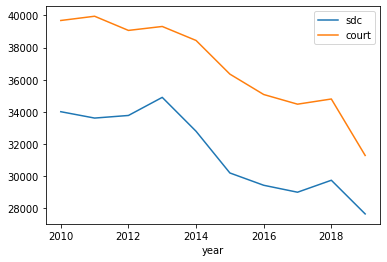

In [8]:
sdc_overlap = sdc_data[(sdc_data.time_step > 0) & (sdc_data.time_step < 120)]
court_overlap = court_data[(court_data.time_step > 0) & (court_data.time_step < 120)]

display_df = pd.DataFrame()
display_df['sdc'] = sdc_overlap.groupby('year').count().max(axis=1)
display_df['court'] = court_overlap.groupby('year').count().max(axis=1)
display_df.iloc[1:].plot()
MISSING_SCRAPED_DATA_SCALE_FACTOR = display_df.sdc.sum() / display_df.court.sum()
MISSING_SCRAPED_DATA_SCALE_FACTOR

In [14]:
sdc_data['scrape_group'] = sdc_data.Defendant.str[0]
sdc_data.groupby(['county', 'scrape_group']).count().max(axis=1).unstack('scrape_group')

scrape_group,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
county,,,,,,,,,,,,,,,,,,,,,,,,,,
Accomack Circuit Court,143.0,497.0,411.0,311.0,71.0,137.0,200.0,363.0,13.0,251.0,129.0,182.0,379.0,115.0,38.0,242.0,3.0,231.0,467.0,287.0,10.0,57.0,379.0,NaN,20.0,3.0
Albemarle Circuit Court,337.0,990.0,833.0,536.0,138.0,425.0,532.0,796.0,25.0,465.0,230.0,373.0,1090.0,143.0,71.0,265.0,26.0,494.0,1146.0,557.0,12.0,99.0,820.0,1.0,36.0,37.0
Alleghany Circuit Court,211.0,537.0,196.0,244.0,58.0,164.0,193.0,496.0,14.0,191.0,212.0,274.0,398.0,173.0,30.0,261.0,5.0,306.0,422.0,271.0,13.0,47.0,474.0,1.0,15.0,4.0
Amelia Circuit Court,101.0,268.0,149.0,94.0,80.0,62.0,113.0,176.0,14.0,144.0,39.0,108.0,211.0,28.0,29.0,130.0,1.0,144.0,209.0,87.0,7.0,14.0,185.0,NaN,8.0,4.0
Amherst Circuit Court,227.0,538.0,547.0,261.0,115.0,212.0,202.0,467.0,25.0,254.0,102.0,245.0,561.0,51.0,51.0,281.0,6.0,271.0,501.0,301.0,4.0,50.0,418.0,NaN,23.0,3.0
Appomattox Circuit Court,56.0,165.0,157.0,82.0,34.0,72.0,68.0,184.0,7.0,120.0,39.0,62.0,231.0,16.0,22.0,108.0,NaN,106.0,126.0,72.0,NaN,8.0,139.0,NaN,7.0,4.0
Arlington Circuit Court,913.0,911.0,2030.0,1205.0,536.0,877.0,241.0,1747.0,161.0,1223.0,748.0,1083.0,221.0,548.0,420.0,265.0,88.0,1443.0,1844.0,1197.0,77.0,412.0,1597.0,3.0,173.0,100.0
Augusta Circuit Court,336.0,1056.0,778.0,459.0,173.0,468.0,409.0,963.0,51.0,290.0,367.0,490.0,986.0,103.0,83.0,466.0,24.0,531.0,1008.0,396.0,7.0,158.0,810.0,NaN,26.0,33.0
Bath Circuit Court,34.0,79.0,83.0,28.0,7.0,16.0,31.0,96.0,6.0,23.0,61.0,34.0,80.0,27.0,3.0,48.0,1.0,69.0,69.0,30.0,NaN,16.0,84.0,NaN,1.0,2.0


In [17]:
incomplete_counties = [
    'Tazewell Circuit Court',
    'Stafford Circuit Court',
    'Norfolk Circuit Court',
    'Suffolk Circuit Court',
    'Henry Circuit Court',
    'Charlottesville Circuit Court',
    'Chesapeake Circuit Court',
    'Henrico Circuit Court',
    'Newport News Circuit Court',
    'Portsmouth Circuit Court',
    'Prince Edward Circuit Court',
    'Pulaski Circuit Court',
    'Richmond City Circuit Court',
    'Staunton Circuit Court',
    'Virginia Beach Circuit Court'
]
print(f'dropping {len(sdc_data[sdc_data.county.apply(lambda x: x in incomplete_counties)])} of {len(sdc_data)} datapoints.')
sdc_data = sdc_data[sdc_data.county.apply(lambda x: x not in incomplete_counties)]


dropping 174872 of 889720 datapoints.


## Using percent served to convert from sentences to lengths of stay (LOS)
This disaggregates by the crime types given to us in the LOS table. You may need to disaggregate differently for whatever policy you're working on, you'll have to think about how to capture the average LOS in whatever categories you work with.

In [9]:
#MURDER

murder_crime_codes = ['18.2-31', '18.2-32', '18.2-33']

first_degree_terms = ['1ST DEG', 'FIRST DEG']
capital_terms = ['CAP'] # and not 'MURDER: NON CAPITAL FELONY'
second_degree_terms = ['2ND DEG', 'SECOND DEG']

sdc_data['FIRST_DEGREE_MURDER'] = (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    sdc_data.Charge.apply(lambda x: any([i in x for i in first_degree_terms]))
)
sdc_data['SECOND_DEGREE_MURDER'] = (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    sdc_data.Charge.apply(lambda x: any([i in x for i in second_degree_terms]))
)
sdc_data['CAPITAL_MURDER'] = (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    sdc_data.Charge.apply(lambda x: any([i in x for i in capital_terms]) & (x !='MURDER: NON CAPITAL FELONY'))
)
sdc_data['OTHER_MURDER'] = (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
    (~sdc_data.CAPITAL_MURDER) &
    (~sdc_data.FIRST_DEGREE_MURDER) &
    (~sdc_data.SECOND_DEGREE_MURDER)
)

In [10]:
#DRUG CRIMES
drug_crimes = ['18.2-248', '18.2-250', '18.2-251',  '18.2-255', '18.2-257', '18.2-258', '18.2-260', '18.2-262', 
                 '18.2-264', '18.2-265']

#Sch I/II Drug Possession and Sale flags by Ellie 
#NOTE: Possession w intent to distribute is categorized as possession in this case

sdc_data['DRUG_POSSESSION'] = sdc_data.Charge.apply(
    lambda x: any([i in x for i in [
        'POSS',
        'PWID', 
    ]])
)
sdc_data.DRUG_POSSESSION = sdc_data.DRUG_POSSESSION & (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
)

sdc_data['DRUG_SALE'] = sdc_data.Charge.apply(
    lambda x: any([i in x for i in [
        'DISTRB',
        'DISTRIB',
        'DIST', 
        'SALE',
        'SELL'
    ]])
)

sdc_data.DRUG_SALE = sdc_data.DRUG_SALE & (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
)

sdc_data['DRUG_OTHER'] = (~sdc_data.DRUG_SALE) & (~sdc_data.DRUG_POSSESSION) & (
    sdc_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
)

In [11]:
#Conspiracy flag by Ellie
#Note: There are a lot more cases over 10 years than the 51 in prison in Feb 2020, but the avg sentence is 18 months
sdc_data['CONSPIRACY'] = sdc_data.Charge.apply(
    lambda x: any([i in x for i in [
        'CONSP'
    ]])
)

In [12]:
# ARSON
ars_crime_codes = ['18.2-77', '18.2-79', '18.2-80',  '18.2-81', '18.2-82', '18.2-83', '18.2-84', '18.2-85', '18.2-86', 
                 '18.2-87', '18.2-88']

sdc_data['ARSON'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in ars_crime_codes]))


# SEX OFFENSE
s_crime_codes = ['18.2-346', '18.2-347', '18.2-348',  '18.2-349', '18.2-355', '18.2-356', '18.2-357', '18.2-361', 
                 '18.2-362', '18.2-365', '18.2-366', '18.2-368', '18.2-370']

sdc_data['SEX_OFFENSE'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in s_crime_codes]))

# DWIs
dwi_crime_codes = ['18.2-272', '18.2-266', '18.2-270', '46.2-341.28', '46.2-341.24', '46.2-341.26', '18.2-268', 
                   '18.2-272']

sdc_data['DWI'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in dwi_crime_codes]))

#WPN
weapons_crime_codes = ['18.2-279', '18.2-280', '18.2-281', '18.2.282', '18.2-283', '18.2-284', '18.2-285', 
                       '18.2-286', '18.2-287', '18.2-289', '18.2-290', '18.2-294', '18.2-295', '18.2-300', 
                       '18.2-304', '18.2-308', '18.2-309', '18.2-311', '18.2-312', '52-52', '53.1-203(4)',
                       '53.1-203(7)', '18.2-56.1', '18.2-56.2']

sdc_data['WEAPON'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in weapons_crime_codes]))


#BUR
burglary_crime_codes = ['18.2-93', '18.2-92', '18.2-89', '18.2-90', '18.2-91', '18.2-94']

sdc_data['BURGLARY'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in burglary_crime_codes]))


#ROB
robbery_crime_codes = ['18.2-58']
sdc_data['ROBBERY'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in robbery_crime_codes]))

# LARCENY
l_crime_codes = ['18.2-23', '18.2-95', '18.2-96',  '18.2-97', '18.2-98', '18.2-100', '18.2-101', '18.2-102', 
                 '18.2-103', '18.2-105', '18.2-107', '18.2-108',  '18.2-109', '18.2-111', '18.2-112', '18.2-113'
                '18.2-114', '18.2-115', '18.2-116', '18.2-117',  '18.2-118', '19.2-361', '18.2-113',
                '55.1-2838', '55.1-2839', '55.1-2840', '18.2-117',  '18.2-118', '19.2-361']
sdc_data['LARCENY'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in l_crime_codes]))


# ASSAULT
a_crime_codes = ['18.2-41', '18.2-42', '18.2-45',  '18.2-51', '18.2-52', '18.2-53', '18.2-54', '18.2-55', '18.2-56', 
                 '18.2-57']
sdc_data['ASSAULT'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in a_crime_codes]))

# RAPE
r_crime_codes = ['18.2-61', '18.2-63', '18.2-64', '18.2-67']
sdc_data['RAPE'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in r_crime_codes]))


# KIDNAPPING
kidnapping_crime_codes = ['18.2-47', '18.2-48', '18.2-49', '18.2-50']
sdc_data['KIDNAPPING'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in kidnapping_crime_codes]))



# MANSLAUGHTER 
manslaughter_crime_codes = ['18.2-35', '18.2-36']
sdc_data['MANSLAUGHTER'] = sdc_data.CodeSection.apply(lambda x: any([i in x for i in manslaughter_crime_codes]))



In [13]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [54]:
# # Deduplicate by hearing date (this is the one that takes forever)
# # As written, each row will have row[crime], which is True if most serious offense is said crime, and 
# # row[crime_ANY], which is True if any offense is said crime.

# def get_most_serious_case(df):
#     sorted_crimes = df.sort_values('compartment_duration')
#     most_serious_crime = sorted_crimes.iloc[-1]
#     most_serious_crime['crimes'] = len(df)
#     for crime in crime_types:
#         most_serious_crime[f'{crime}_ANY'] = df[crime].any()
    
#     sorted_crimes = sorted_crimes.iloc[:-1]
#     sorted_crimes.ConcurrentConsecutive = sorted_crimes.ConcurrentConsecutive.map(
#         {'Consecutive': 1, 'Concurrent': 0}
#     ).fillna(0)
#     most_serious_crime['total_sentence_months'] = most_serious_crime.compartment_duration + \
#         (sorted_crimes.ConcurrentConsecutive * sorted_crimes.compartment_duration).sum()
    

#     return most_serious_crime

# sdc_data = sdc_data.groupby(['person_id', 'Disposition Date'], as_index=False).apply(get_most_serious_case)

In [56]:
# sdc_data.to_csv('deduped_ETC_data.csv')

In [14]:
def check_for_crime_type(x, crime_type):
    if x[crime_type]:
        return crime_type
    return x['crime_type']
        
sdc_data['crime_type'] = None
for crime_type in crime_types:
    sdc_data['crime_type'] = sdc_data.apply(lambda x: check_for_crime_type(x, crime_type), axis=1)

In [3]:
# Uncomment either the first line to upload (if first time) or  uncomment the second line to import if 
# you've already created the table on your computer.

# court_data.to_csv('deduped_va_court_data.csv')
# court_data = pd.read_csv('../state/VA/VA_data/deduped_va_court_data.csv')

# Cleaning validation
Remaining cleaning todos:
* remove overlap between crime types
* check LOS of missed crimes to LOS of caught crimes, if missed crimes are statistically different, that's problem

In [65]:
#Check for overlap, this should be all zeros

for crime in crime_types:
    for other_crime in crime_types:
        if other_crime != crime:
            print(crime, other_crime, len(court_data[court_data[crime] & court_data[other_crime]]))

DRUG_POSSESSION DRUG_SALE 3641
DRUG_POSSESSION DRUG_OTHER 0
DRUG_POSSESSION CONSPIRACY 229
DRUG_POSSESSION KIDNAPPING 0
DRUG_POSSESSION MANSLAUGHTER 0
DRUG_POSSESSION LARCENY 0
DRUG_POSSESSION ASSAULT 0
DRUG_POSSESSION ROBBERY 0
DRUG_POSSESSION BURGLARY 0
DRUG_POSSESSION WEAPON 0
DRUG_POSSESSION DWI 0
DRUG_POSSESSION RAPE 0
DRUG_POSSESSION SEX_OFFENSE 0
DRUG_POSSESSION ARSON 0
DRUG_SALE DRUG_POSSESSION 3641
DRUG_SALE DRUG_OTHER 0
DRUG_SALE CONSPIRACY 1155
DRUG_SALE KIDNAPPING 0
DRUG_SALE MANSLAUGHTER 0
DRUG_SALE LARCENY 0
DRUG_SALE ASSAULT 0
DRUG_SALE ROBBERY 0
DRUG_SALE BURGLARY 0
DRUG_SALE WEAPON 0
DRUG_SALE DWI 0
DRUG_SALE RAPE 0
DRUG_SALE SEX_OFFENSE 0
DRUG_SALE ARSON 0
DRUG_OTHER DRUG_POSSESSION 0
DRUG_OTHER DRUG_SALE 0
DRUG_OTHER CONSPIRACY 780
DRUG_OTHER KIDNAPPING 0
DRUG_OTHER MANSLAUGHTER 0
DRUG_OTHER LARCENY 0
DRUG_OTHER ASSAULT 0
DRUG_OTHER ROBBERY 0
DRUG_OTHER BURGLARY 0
DRUG_OTHER WEAPON 0
DRUG_OTHER DWI 0
DRUG_OTHER RAPE 0
DRUG_OTHER SEX_OFFENSE 0
DRUG_OTHER ARSON 0
CONSP

In [11]:
def check_for_crime_type(x, crime_type):
    if x[crime_type]:
        return crime_type
    return x['crime_type']
        
court_data['crime_type'] = None
for crime_type in crime_types:
    court_data['crime_type'] = court_data.apply(lambda x: check_for_crime_type(x, crime_type), axis=1)

In [54]:
a = sdc_data.groupby(['city', 'crime_type']).count().max(axis=1).unstack('crime_type')
a.loc['no'] /= 587615
a.loc['yes'] /=292617
a

crime_type,ARSON,ASSAULT,BURGLARY,CAPITAL_MURDER,CONSPIRACY,DRUG_OTHER,DRUG_POSSESSION,DRUG_SALE,DWI,FIRST_DEGREE_MURDER,KIDNAPPING,LARCENY,MANSLAUGHTER,OTHER_MURDER,RAPE,ROBBERY,SECOND_DEGREE_MURDER,SEX_OFFENSE,WEAPON
city,,,,,,,,,,,,,,,,,,,
no,0.004239,0.084840,0.030578,0.000434,0.004767,0.033912,0.088241,0.066334,0.059736,0.000657,0.010454,0.145582,0.001741,0.002786,0.016953,0.011273,0.000250,0.004823,0.028046
yes,0.003599,0.093754,0.026116,0.000390,0.004272,0.025819,0.128205,0.043993,0.045524,0.000926,0.010085,0.147401,0.000916,0.003250,0.012706,0.018495,0.000277,0.003865,0.027562


In [51]:
sdc_data.groupby('city').count().max(axis=1)

city
no     587615
yes    292617
dtype: int64

In [33]:
# This is to compare population to population in terms of breakdown in the data vs in the excel sheet
# --> they mostly line up pretty well!

LOS_data = court_data.groupby('crime_type').mean().total_sentence_months
crime_type_counts = court_data.groupby('crime_type').count().total_sentence_months
crime_type_counts * LOS_data / np.dot(crime_type_counts, LOS_data)

crime_type
ARSON                   0.005177
ASSAULT                 0.143358
BURGLARY                0.062174
CAPITAL_MURDER          0.010521
CONSPIRACY              0.003471
DRUG_OTHER              0.042558
DRUG_POSSESSION         0.090372
DRUG_SALE               0.105417
DWI                     0.021677
FIRST_DEGREE_MURDER     0.062288
KIDNAPPING              0.025742
LARCENY                 0.112850
MANSLAUGHTER            0.007296
OTHER_MURDER            0.023223
RAPE                    0.106514
ROBBERY                 0.081753
SECOND_DEGREE_MURDER    0.011254
SEX_OFFENSE             0.010185
WEAPON                  0.074170
Name: total_sentence_months, dtype: float64

In [17]:
# Check for crime codes that aren't being caught right now...
missing = court_data[court_data.apply(lambda x: all([not x[crime] for crime in crime_types]), axis=1)]
missing.groupby('CodeSection').count().sort_values('HearingDate', ascending=False).iloc[:300]

,Unnamed: 0,HearingDate,HearingResult,HearingType,Filed,Commencedby,Charge,ChargeType,Class,JailPenitentiary,ConcurrentConsecutive,SentenceTime,SentenceSuspended,ProbationType,ProbationTime,ProbationStarts,AppealedDate,person_id,effective_sentence_months,day,month,year,ASSAULT_ON_POLICE,THIRD_DWI_10YR,DRUG_INTENT,DRUG_SALE,2ND,SECOND_PWID,FELON_GUN_POSS,3RD,THIRD_PWID,FOURTH_DWI_10YR,PROPOSE_SEX_COMPUTER,REVOKED_LICENSE,THIRD_DWI_5YR,crimes,ASSAULT_ON_POLICE_ANY,THIRD_DWI_10YR_ANY,SECOND_PWID_ANY,FELON_GUN_POSS_ANY,THIRD_PWID_ANY,FOURTH_DWI_10YR_ANY,PROPOSE_SEX_COMPUTER_ANY,REVOKED_LICENSE_ANY,THIRD_DWI_5YR_ANY,total_sentence_months,FIRST_DEGREE_MURDER,SECOND_DEGREE_MURDER,CAPITAL_MURDER,OTHER_MURDER,DRUG_POSSESSION,DRUG_OTHER,CONSPIRACY,ARSON,SEX_OFFENSE,DWI,WEAPON,BURGLARY,ROBBERY,LARCENY,ASSAULT,RAPE,KIDNAPPING,MANSLAUGHTER
CodeSection,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B.46.2-301,11501,11501,11501,11501,11501,11501,11501,11501,9456,8472,2070,11501,11501,3213,3183,2382,15,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501
A.46.2-862,6419,6419,6419,6419,6419,6419,6419,6419,4878,1040,168,6419,6419,492,491,355,3,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419
18.2-178,6352,6352,6352,6352,6352,6352,6352,6352,5679,5887,2093,6352,6352,4219,3643,2768,46,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352
19.2-128,5359,5359,5359,5359,5359,5359,5359,5359,4351,4007,1056,5359,5359,1380,1194,924,8,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359
19.2-306,5315,5315,5315,5315,5315,5315,5315,5315,4172,4570,1106,5315,5315,1664,1458,996,16,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315
18.2-172,4091,4091,4091,4091,4091,4091,4091,4091,3674,3949,1541,4091,4091,3187,2758,2186,21,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091
18.2-104,3698,3698,3698,3698,3698,3698,3698,3698,3495,3677,1122,3698,3698,2780,2462,2103,32,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698
B.46.2-357,3676,3676,3676,3676,3676,3676,3676,3676,3087,3609,1034,3676,3676,2365,2046,1595,44,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676
C.46.2-862,3097,3097,3097,3097,3097,3097,3097,3097,2570,381,79,3097,3097,139,139,96,5,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097


# Preprocessing

## TODOs
* can't just drop 0 length sentences
* recidivism
* separate out jail
* total population (2019/2020 by month)

In [52]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching
scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type', 'city']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population', 'city': 'age'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor / MISSING_SCRAPED_DATA_SCALE_FACTOR
outflows_data = outflows_data[(outflows_data['time_step'] < 120) & (outflows_data['time_step'] > 0)]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

,time_step,crime_type,age,total_population,compartment,outflow_to
68473,0,ASSAULT,no,7.779404,pretrial,prison
68474,0,ASSAULT,yes,3.889702,pretrial,prison
68475,0,BURGLARY,no,5.834553,pretrial,prison
68476,0,DRUG_POSSESSION,no,11.669106,pretrial,prison
68477,0,DRUG_POSSESSION,yes,5.834553,pretrial,prison


In [38]:
scale_factor

1.67744074763648

<AxesSubplot:xlabel='time_step'>

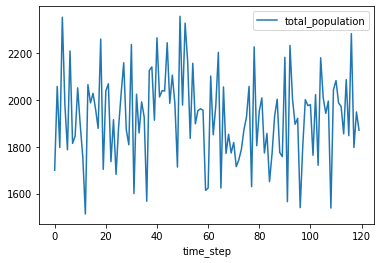

In [39]:
outflows_data.groupby('time_step').sum().plot()

In [51]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type', 'city'
]).count()[['Address']].reset_index().rename({'Address': 'total_population', 'city': 'age'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types) * 2,
    'total_population': [1] * len(crime_types) * 2,
    'compartment': ['release'] * len(crime_types) * 2,
    'outflow_to': ['release'] * len(crime_types) * 2,
    'crime_type': crime_types * 2,
    'age': ['yes'] * len(crime_types) + ['no'] * len(crime_types),
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,age,total_population,compartment,outflow_to
0,1.0,ARSON,no,79.0,prison,release
1,1.0,ARSON,yes,37.0,prison,release
2,1.0,ASSAULT,no,3183.0,prison,release
3,1.0,ASSAULT,yes,1936.0,prison,release
4,1.0,BURGLARY,no,539.0,prison,release


In [50]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(9 * 12, 9 * 12 + 34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [53]:
simulation_tag = "ETC_cities_dec4"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/policy_configurations/ETC_city_model_inputs.yaml',
)

# Modeling

In [54]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/policy_configurations/ETC_city_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1852: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 39618 results
transitions_data returned 3394 results


crime_type            age  compartment  outflow_to
CAPITAL_MURDER        no   pretrial     prison        50.833333
                      yes  pretrial     prison        85.833333
CONSPIRACY            yes  pretrial     prison        58.333333
FIRST_DEGREE_MURDER   no   pretrial     prison        44.166667
                      yes  pretrial     prison        52.500000
MANSLAUGHTER          yes  pretrial     prison        62.500000
SECOND_DEGREE_MURDER  no   pretrial     prison        76.666667
                      yes  pretrial     prison        91.666667
dtype: float64%


total_population_data returned 34 results


initialization time:  248.56358790397644


simulation_time:  202.72368001937866


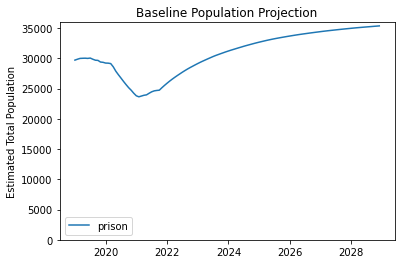

In [55]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

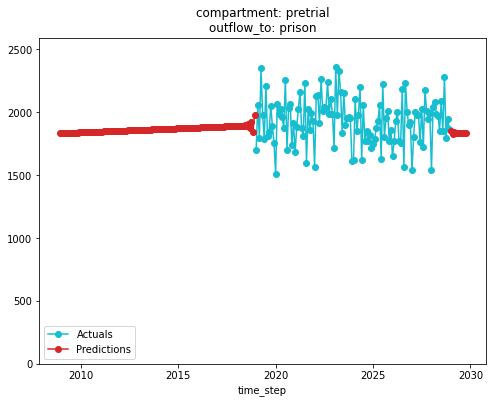

In [76]:
spark_sim.get_arima_output_plots('baseline_projections')

CONSPIRACY 0.9870127633194358
CONSPIRACY 0.9870127633194358
DRUG_POSSESSION 0.9861358812753698
DRUG_POSSESSION 0.9861358812753698
DRUG_SALE 0.987086467431631
DRUG_SALE 0.987086467431631
DRUG_OTHER 0.987200022047929
DRUG_OTHER 0.987200022047929
KIDNAPPING 0.9898681085993776
KIDNAPPING 0.9898681085993776
MANSLAUGHTER 0.9899289122821391
MANSLAUGHTER 0.9899289122821391
LARCENY 0.988143534704725
LARCENY 0.988143534704725
WEAPON 0.9871066632208532
WEAPON 0.9871066632208532
ASSAULT 0.9891239991405415
ASSAULT 0.9891239991405415
ROBBERY 0.9907903471388435
ROBBERY 0.9907903471388435
BURGLARY 0.9893472030958566
BURGLARY 0.9893472030958566
DWI 0.9861855178783021
DWI 0.9861855178783021
RAPE 0.9882281977423873
RAPE 0.9882281977423873
SEX_OFFENSE 0.9875298570227083
SEX_OFFENSE 0.9875298570227083
ARSON 0.9891530418250951
ARSON 0.9891530418250951
FIRST_DEGREE_MURDER 0.9883301363917156
FIRST_DEGREE_MURDER 0.9883301363917156
SECOND_DEGREE_MURDER 0.9893600148305318
SECOND_DEGREE_MURDER 0.9893600148305318


simulation_time:  202.51141691207886


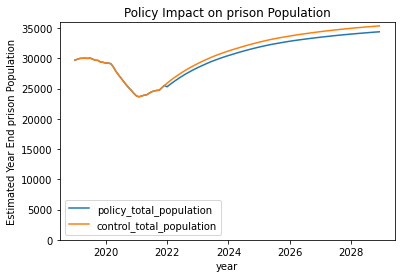

In [62]:
# not actually using this yet, but I suspect moving people down ETC levels will be a more accurate handling
# for our next draft.
ETC_LEVEL_BY_CRIME = pd.DataFrame({
    'CONSPIRACY': {1:27, 2: 5, 3: 12, 4:7},
    'DRUG_POSSESSION': {1:574, 2:78, 3:177, 4:171},
    'DRUG_SALE': {1:1415, 2:245, 3:629, 4:458},
    'DRUG_OTHER': {1:1989, 2:323, 3:806, 4:629},
    'KIDNAPPING': {1:641, 2:203, 3:430, 4:304},
    'MANSLAUGHTER': {1:175, 2:44, 3:122, 4:96},
    'LARCENY': {1:1289, 2:190, 3:447, 4:591},
    'WEAPON': {1:346, 2:45, 3:100, 4:158},
    'ASSAULT': {1:1391, 2:354, 3:685, 4:728},
    'ROBBERY': {1:1491, 2:488, 3:1049, 4:1014},
    'BURGLARY': {1:740, 2:165, 3:413, 4:476},
    'DWI': {1: 101, 2: 14, 3: 28, 4:24},
    'RAPE': {1:1355, 2:304, 3:917, 4:405},
    'SEX_OFFENSE': {1:343, 2:60, 3:180, 4:80},
    'ARSON': {1:40, 2:13, 3:14, 4:26},
    'FIRST_DEGREE_MURDER': {1:868, 2:288, 3:534, 4:313},
    'SECOND_DEGREE_MURDER': {1:296, 2: 109, 3:224, 4:148},
    'OTHER_MURDER': {1:1327, 2:432, 3:833, 4:498},
    'CAPITAL_MURDER': {1:163, 2:35, 3:75, 4:37}
}).transpose()


# Note that I just use 0.85 as the new LOS in all cases. This is because we talked about doubling time off,
# but VA has a sentence reduction cap at 15%, so that'd just push everyone up to the cap.
def increase_ETCs(crime):
    crime_avg_LOS = LOS_BY_CRIME[crime]
    crime_levels = ETC_LEVEL_BY_CRIME.loc[crime]
    crime_total_count = sum(list(crime_levels.values))
    
    
# If ETC were truly the only way to get time off your sentence, this would work. This calculates a
# "utilization factor," i.e. the amount of maximal ETC the average person is actually earning. However, that
# factor turns out to be greater than 1, indicating that there are other ways to earn time off and also probably
# that people basically earn 100% of possible ETC. Thus I switched to the methodology below, which assumes 100%.

#     utilization_factor = (1 - crime_avg_LOS) * crime_total_count / (
#         (4.5 / 34.5) * crime_levels[1] + (3/33) * crime_levels[2] + (1.5/31.5) * crime_levels[3]
#     )

#     new_level_LOS = {
#         1: max(0.85, 1 - 15 / 45 * utilization_factor),
#         2: max(0.85, 1 - 10 / 40 * utilization_factor),
#         3: max(0.85, 1 - 5 / 35 * utilization_factor),
#         4: 1
#     }
    
    
    non_ETC_LOS_factor = crime_avg_LOS * crime_total_count / (
        (30 / 34.5) * crime_levels[1] + (30/33) * crime_levels[2] + (30/31.5) * crime_levels[3] + crime_levels[4]
    )
    
    new_level_LOS = {
        1: max(0.85, (1 - 15 / 45) * non_ETC_LOS_factor),
        2: max(0.85, (1 - 10 / 40) * non_ETC_LOS_factor),
        3: max(0.85, (1 - 5 / 35) * non_ETC_LOS_factor),
        4: max(0.85, 1 * non_ETC_LOS_factor)
    }
    
    new_LOS = sum([crime_levels[i] * new_level_LOS[i] for i in range(1,5)]) / crime_total_count
    
#     print(crime, utilization_factor)
    print(crime, non_ETC_LOS_factor)
    
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': ['release'],
                       'reduction_size': [(LOS_BY_CRIME[crime] - new_LOS) / LOS_BY_CRIME[crime]], 
                       'affected_fraction': [1]
                   }),
                   reduction_type='*',
                   retroactive=True)

policy_list = []
for crime in crime_types:
    policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': crime, 'age': 'no'},
                                           policy_ts=144,
                                           apply_retroactive=True))
    policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': crime, 'age': 'yes'},
                                           policy_ts=144,
                                           apply_retroactive=True))



test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [59]:
LOS_BY_CRIME

{'CONSPIRACY': 0.899,
 'DRUG_POSSESSION': 0.897,
 'DRUG_SALE': 0.902,
 'DRUG_OTHER': 0.901,
 'KIDNAPPING': 0.913,
 'MANSLAUGHTER': 0.916,
 'LARCENY': 0.907,
 'WEAPON': 0.905,
 'ASSAULT': 0.912,
 'ROBBERY': 0.92,
 'BURGLARY': 0.917,
 'DWI': 0.893,
 'RAPE': 0.906,
 'SEX_OFFENSE': 0.9,
 'ARSON': 0.914,
 'FIRST_DEGREE_MURDER': 0.907,
 'SECOND_DEGREE_MURDER': 0.914,
 'OTHER_MURDER': 0.908,
 'CAPITAL_MURDER': 0.898}

In [65]:
# maybe don't run this one yourself, no need to spam our output database :)
simulation_tag = 'VA_ETC_city_dec4'
outputs = spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

In [87]:
def city(simulation_group):
    if simulation_group[-3:] == 'yes':
        return 'yes'
    return 'no'

policy_outputs = spark_sim.simulator.pop_simulations['policy'].get_population_projections()
policy_outputs = policy_outputs[
    (policy_outputs.compartment == 'prison') & (policy_outputs.time_step == (144 + 5 * 12))
]
policy_outputs['city'] = policy_outputs.simulation_group.apply(city)
policy_outputs = policy_outputs.groupby('city').total_population.sum()

baseline_outputs = spark_sim.simulator.pop_simulations['control'].get_population_projections()
baseline_outputs = baseline_outputs[
    (baseline_outputs.compartment == 'prison') & (baseline_outputs.time_step == (144 + 5 * 12))
]
baseline_outputs['city'] = baseline_outputs.simulation_group.apply(city)
baseline_outputs = baseline_outputs.groupby('city').total_population.sum()

urban_impacts = pd.DataFrame()

urban_impacts['total'] = baseline_outputs - policy_outputs
urban_impacts['per_prison_capita'] = (baseline_outputs - policy_outputs) / baseline_outputs
urban_impacts

<ipython-input-87-00b5f93db3d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_outputs['city'] = policy_outputs.simulation_group.apply(city)
<ipython-input-87-00b5f93db3d2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_outputs['city'] = baseline_outputs.simulation_group.apply(city)


,total,per_prison_capita
city,,
no,658.312432,0.027029
yes,261.833929,0.026024


In [78]:
circuit_populations = {
    'Suffolk Circuit Court': 94324,
    'Roanoke City Circuit Court': 100011,
    'York County/Poquoson Circuit Court': (70045 + 12460),
    'Virginia Beach Circuit Court': 459470,
    'Winchester Circuit Court': 2812,
    'Salem Circuit Court': 25346,
    'Williamsburg/James City County Circuit Court': (78254 + 15425 ),
    'Staunton Circuit Court': 25750,
    'Richmond City Circuit Court': 226610,
    'Radford Circuit Court': 16070,
    'Waynesboro Circuit Court': 22196,
    'Portsmouth Circuit Court': 97915,
    'Norfolk Circuit Court': 238005,
    'Petersburg Circuit Court': 33458,
    'Chesapeake Circuit Court': 249422,
    'Danville Circuit Court': 42590,
    'Martinsville Circuit Court': 13485,
    'Newport News Circuit Court': 186247,
    'Hopewell Circuit Court': 23033,
    'Buena Vista Circuit Court': 6641,
    'Bristol Circuit Court': 17219,
    'Charlottesville Circuit Court': 46553,
    'Colonial Heights Circuit Court': 18170,
    'Fredericksburg Circuit Court': 27982,
    'Surry Circuit Court': 6561,
    'Prince George Circuit Court': 43010,
    'Shenandoah Circuit Court': 44186,
    'Rockbridge Circuit Court': 22650,
    'Warren Circuit Court': 40727,
    'Wythe Circuit Court': 28290,
    'Spotsylvania Circuit Court': 140032,
    'Roanoke County Circuit Court': 96929,
    'Page Circuit Court': 23709,
    'Lunenburg Circuit Court': 11936,
    'Southampton Circuit Court': 17966,
    'Smyth Circuit Court': 29800,
    'Wise Circuit Court': 36130,
    'Tazewell Circuit Court': 40429,
    'Richmond County Circuit Court': 8923,
    'Scott Circuit Court': 21576,
    'Sussex Circuit Court': 10829,
    'Prince William Circuit Court': 482209,
    'Russell Circuit Court': 25781,
    'Nelson Circuit Court': 14775,
    'Stafford Circuit Court': 156927,
    'Prince Edward Circuit Court': 21849,
    'Isle of Wight Circuit Court': 38606,
    'Rappahannock Circuit Court': 7348,
    'Westmoreland Circuit Court': 18477,
    'Rockingham Circuit Court': 83757,
    'Orange Circuit Court': 34254,
    'Powhatan Circuit Court': 30333,
    'Pulaski Circuit Court': 33800,
    'Washington Circuit Court': 53935,
    'Nottoway Circuit Court': 15642,
    'Montgomery Circuit Court': 99721,
    'Northumberland Circuit Court': 11839,
    'Louisa Circuit Court': 37596,
    'Northampton Circuit Court': 12282,
    'Middlesex Circuit Court': 10625,
    'Loudoun Circuit Court': 420959,
    'Pittsylvania Circuit Court': 60501,
    'Mecklenburg Circuit Court': 30319,
    'Lee Circuit Court': 22173 ,
    'Greensville Circuit Court': 11391,
    'Buckingham Circuit Court': 16824,
    'Augusta Circuit Court': 77487,
    'Mathews Circuit Court': 8533,
    'Lancaster Circuit Court': 10919,
    'Patrick Circuit Court': 17608,
    'King William Circuit Court': 17810,
    'New Kent Circuit Court': 22945,
    'Greene Circuit Court': 2552,
    'Buchanan Circuit Court': 2355,
    'Grayson Circuit Court': 15333,
    'Arlington Circuit Court': 238643,
    'Highland Circuit Court': 2232,
    'Henry Circuit Court': 50948,
    'King George Circuit Court': 26723,
    'Madison Circuit Court': 13837,
    'Goochland Circuit Court': 24727,
    'Fluvanna Circuit Court': 27249 ,
    'Bath Circuit Court': 4209,
    'Accomack Circuit Court': 33413,
    'Chesterfield Circuit Court': 364548 ,
    'Bedford Circuit Court': 79462 ,
    'Campbell Circuit Court': 55696,
    'Dickenson Circuit Court': 14124 ,
    'Albemarle Circuit Court': 112395 ,
    'Dinwiddie Circuit Court': 27947,
    'Bland Circuit Court': 6270,
    'Alleghany Circuit Court': 15223,
    'Botetourt Circuit Court': 33596,
    'Amelia Circuit Court': 13265,
    'Caroline Circuit Court': 30887,
    'Amherst Circuit Court': 31307,
    'Carroll Circuit Court': 29155,
    'Appomattox Circuit Court': 16119,
    'Brunswick Circuit Court': 15849 ,
    'Charles City Circuit Court': 6773 ,
    'Charlotte Circuit Court': 11529,
    'Essex Circuit Court': 10599 ,
    'Hampton Circuit Court': 137148 ,
    'Fauquier Circuit Court': 72972,
    'Clarke Circuit Court': 14783 ,
    'Floyd Circuit Court': 15476 ,
    'Craig Circuit Court': 4892,
    'Culpeper Circuit Court': 52552 ,
    'Frederick Circuit Court': 91419 ,
    'Cumberland Circuit Court': 9675 ,
    'Giles Circuit Court': 16787 ,
    'Gloucester Circuit Court': 38711 ,
    'Halifax Circuit Court': 34022,
    'Hanover Circuit Court': 109979 ,
    'Lynchburg Circuit Court': 79009,
    'Henrico Circuit Court': 334389 ,
    'Clifton Forge Circuit Court': 3884,
    'Franklin Circuit Court':  (54477 + 8180)
}

city_pop = 0
county_pop = 0

for county, pop in circuit_populations.items():
    if county in cities:
        city_pop += pop * MISSING_SCRAPED_DATA_SCALE_FACTOR
    elif county in non_city_counties:
        county_pop += pop

print(city_pop, county_pop)

1853945.1500507488 4863571


In [89]:
urban_impacts['per_capita'] = (baseline_outputs - policy_outputs) / pd.Series({'no': county_pop, 'yes': city_pop})

urban_impacts.total = urban_impacts.total / urban_impacts.total.sum() * 100
urban_impacts.per_capita *= 29970
urban_impacts

In [91]:
urban_impacts

,total,per_prison_capita,per_capita
city,,,
no,71.544317,0.027029,4.056613
yes,28.455683,0.026024,4.232683
